In [1]:
# Ocean Heat Budget Analyses in the Antarctica continental shelf (WAOM)

# Fabio B Dias - 3 May 2023
# Description:
#     this script compares methods of calculate the OHC and surface heat flux integrated over the continental shelf
#     - update to xarray open_mfdataset from open_dataset brought new functions more efficient to calculate model layer thickness (dz)
# and ocean heat content tendencies (rho0*Cp*dT/dt). 

# - update 23/8/23: re-ran waom10 saving daily outputs in 5-days files.
# I suspect that the monthly files with unequal number of time-fields 
# causes differences in the dt for his and avg files, reflected in the 
# residue for the Antarctic shelf seas heat budget.

In [2]:
# read nc output from WAOM 10km run

import xarray as xr
# import pandas as p
import numpy as np
import numpy.ma as ma
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps

from datetime import datetime, timedelta

from netCDF4 import Dataset
from netCDF4 import num2date, date2num
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps

import gsw

import pyresample

from dask.distributed import Client
import logging
import warnings
warnings.filterwarnings('ignore')

In [3]:
client = Client(threads_per_worker=1, memory_limit=0, silence_logs=logging.ERROR)
print(client)

<Client: 'tcp://127.0.0.1:33741' processes=28 threads=28>


In [4]:
fig_path = '/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Contour_isobath/'

In [5]:
    %%time
    
    # using xr.open_mfdataset
    
    vars2drop = ["ubar","vbar","w","Hsbl","Hbbl","swrad"]
    
    ds = xr.open_mfdataset(paths="/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_20yr_diag_daily/ocean_avg_00*.nc" , chunks={'eta_rho': '200MB'}, parallel=bool, drop_variables=vars2drop, decode_times=False) # , concat_dim="ocean_time"
    
    #- preserving 5-days avgs
    zeta = ds.variables["zeta"] 
    temp = ds.variables["temp"] 
    salt = ds.variables["salt"]
    shflux = ds.variables["shflux"] 
    ssflux = ds.variables["ssflux"]
    m = ds.variables["m"]
    HvomT = ds.variables["Hvom_temp"]       ## !!! Huon_temp/Hvom_temp were not saved in the original run
    HuonT = ds.variables["Huon_temp"]       ## now it's running here: /scratch/gi0/fbd581/waom4extend_shflim_S_0.25Q/output_yr10_diag
    Hvom = ds.variables["Hvom"] 
    Huon = ds.variables["Huon"] 
    time_avg = ds.variables["ocean_time"] 
    ice_draft = ds.variables["zice"]
    
    mask_zice = ma.masked_where(ice_draft < 0, np.ones(ice_draft.shape))
    mask_outice = ma.masked_where(ice_draft >= 0, np.ones(ice_draft.shape))
    
    print("Vtransform=2")
    #  New formulation (Vtransform(ng) = 2):
    #
    #         z_w(x,y,s,t) = zeta(x,y,t) + [zeta(x,y,t)+ h(x,y)] * Zo_w
    #                 Zo_w = [hc * s(k) + C(k) * h(x,y)] / [hc + h(x,y)]
    hwater = ds.h- abs(ds.zice) # replace ds.h for hwater below
    Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * hwater) / (ds.hc + hwater)
    z_rho = ds.zeta + (ds.zeta + hwater) * Zo_rho 
    
    Zo_w = (ds.hc * ds.s_w + ds.Cs_w * hwater) / (ds.hc + hwater)
    z_w = ds.zeta + (ds.zeta + hwater) * Zo_w 
    
    dg = xr.open_dataset("/g/data/hh5/tmp/access-om/fbd581/ROMS/waom10_frc/waom10extend_grd.nc")
    
    lat_rho = dg.variables["lat_rho"]
    lon_rho = dg.variables["lon_rho"]
    lat_u = dg.variables["lat_u"]
    lon_u = dg.variables["lon_u"]
    lat_v = dg.variables["lat_v"]
    lon_v = dg.variables["lon_v"]
    pm = dg.variables["pm"]
    pn = dg.variables["pn"]
    h = dg.variables["h"]
    zice = dg.variables["zice"]
    
    ds.coords['lat_rho']=lat_rho.transpose() # put lat_rho into ds dataset
    ds.coords['lon_rho']=lon_rho.transpose() # put lon_rho into ds dataset
    ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])
    
    ds.close()
    dg.close()
    
    # calculate surface sigma_theta (potential density)
    sigma_t_sfc = gsw.rho(salt[:,-1,:,:],temp[:,-1,:,:],0) - 1000
    area=np.divide(1,pm*pn)

Vtransform=2
CPU times: user 30.7 s, sys: 7.52 s, total: 38.3 s
Wall time: 1min 10s


In [6]:
    # load horizontal diffusion of heat calculated online:
    	# float temp_hdiff(ocean_time, s_rho, eta_rho, xi_rho) ;
    
    ds = xr.open_mfdataset(paths="/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_20yr_diag_daily/ocean_dia_00*.nc" , chunks={'eta_rho': '200MB'}, parallel=bool, drop_variables=vars2drop, decode_times=False)
    temp_hdiff = ds.variables["temp_hdiff"] 
    temp_vdiff = ds.variables["temp_vdiff"] 
    temp_sdiff = ds.variables["temp_sdiff"]  #"potential temperature, horizontal S-diffusion rotated tensor term"
    temp_hadv = ds.variables["temp_hadv"] 
    temp_vadv = ds.variables["temp_vadv"] 
    ds.close()

In [7]:
    %%time
    # method 2 to calculate Dz:
    # z_w=z_w.chunks(chunks={'eta_rho': '200MB'}) # couldn't change chunks.
    
    Z_w = z_w.transpose('ocean_time','s_w','eta_rho','xi_rho')
    print(z_w.shape, Z_w.shape)
    dz = np.diff(Z_w,axis=1)


(365, 560, 630, 32) (365, 32, 560, 630)
CPU times: user 32.8 s, sys: 1min, total: 1min 32s
Wall time: 1min 29s


In [8]:
# convert dz to xarray:
months=np.arange(0,365)*(1/30.41667)
# save to netcdf file:
coordinatesC=dict(ocean_time=months, s_rho=(['s_rho'], np.arange(0,31)), eta_rho=(['eta_rho'], np.arange(0,560)), xi_rho=(['xi_rho'], np.arange(0,630)))

dz_xr = xr.DataArray(dz, coords = coordinatesC, dims = ['ocean_time','s_rho','eta_rho','xi_rho'])


In [9]:
    temp_vadv.load()
    temp_hadv.load()

<xarray.Variable (ocean_time: 365, s_rho: 31, eta_rho: 560, xi_rho: 630)> Size: 16GB
array([[[[ 1.67195776e-06,  1.67195776e-06, -1.55184694e-06, ...,
          -5.58577938e-07, -3.37030087e-07, -3.37030087e-07],
         [ 1.67195776e-06,  1.67195776e-06, -1.55184694e-06, ...,
          -5.58577938e-07, -3.37030087e-07, -3.37030087e-07],
         [ 5.72446106e-06,  5.72446106e-06,  6.07138702e-07, ...,
          -3.50623537e-07, -4.94417066e-07, -4.94417066e-07],
         ...,
         [-1.10337260e-06, -1.10337260e-06, -1.98637213e-06, ...,
          -1.53627491e-06,  3.07586720e-06,  3.07586720e-06],
         [ 5.40510018e-06,  5.40510018e-06, -4.85127293e-06, ...,
           3.81703330e-06, -3.25185852e-06, -3.25185852e-06],
         [ 5.40510018e-06,  5.40510018e-06, -4.85127293e-06, ...,
           3.81703330e-06, -3.25185852e-06, -3.25185852e-06]],

        [[ 2.82995120e-06,  2.82995120e-06, -2.41523503e-06, ...,
          -5.15553950e-07, -2.73867641e-07, -2.73867641e-07],
         [ 2.82995120e-06,  2.82995120e-06, -2.41523503e-06, ...,
          -5.15553950e-07, -2.73867641e-07, -2.73867641e-07],
         [ 4.88152500e-06,  4.88152500e-06, -1.31782642e-07, ...,
          -3.13384078e-07, -3.25401231e-07, -3.25401231e-07],
...
          -3.26827139e-05, -8.35643459e-06, -8.35643459e-06],
         [ 4.08480417e-07,  4.08480417e-07, -3.17359991e-06, ...,
           3.71903770e-05,  6.07571783e-05,  6.07571783e-05],
         [ 4.08480417e-07,  4.08480417e-07, -3.17359991e-06, ...,
           3.71903770e-05,  6.07571783e-05,  6.07571783e-05]],

        [[ 4.63790493e-05,  4.63790493e-05,  6.02087748e-05, ...,
           3.34388496e-05,  3.46523084e-05,  3.46523084e-05],
         [ 4.63790493e-05,  4.63790493e-05,  6.02087748e-05, ...,
           3.34388496e-05,  3.46523084e-05,  3.46523084e-05],
         [-2.61633177e-05, -2.61633177e-05, -8.93851848e-06, ...,
           1.46763578e-05,  2.08350975e-05,  2.08350975e-05],
         ...,
         [-4.42021928e-06, -4.42021928e-06, -1.29115560e-05, ...,
          -6.53078496e-06,  1.41635974e-05,  1.41635974e-05],
         [ 1.12959879e-05,  1.12959879e-05,  2.83039644e-05, ...,
           4.32215566e-05,  1.01863363e-04,  1.01863363e-04],
         [ 1.12959879e-05,  1.12959879e-05,  2.83039644e-05, ...,
           4.32215566e-05,  1.01863363e-04,  1.01863363e-04]]]],
      dtype=float32)
Attributes:
    long_name:  potential temperature, horizontal advection term
    units:      Celsius second-1
    time:       ocean_time
    field:      temp_hadv, scalar, series

In [10]:
temp_vadv_dz = temp_vadv*dz_xr
temp_hadv_dz = temp_hadv*dz_xr

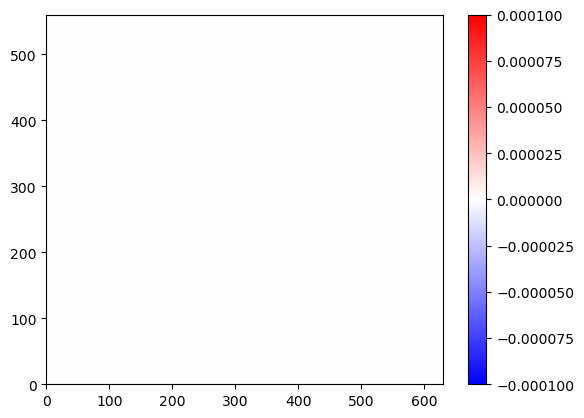

In [11]:
plt.pcolormesh(temp_vadv_dz.sum('s_rho').mean('ocean_time'), cmap='bwr', vmin=-0.0001, vmax=0.0001)
plt.colorbar()

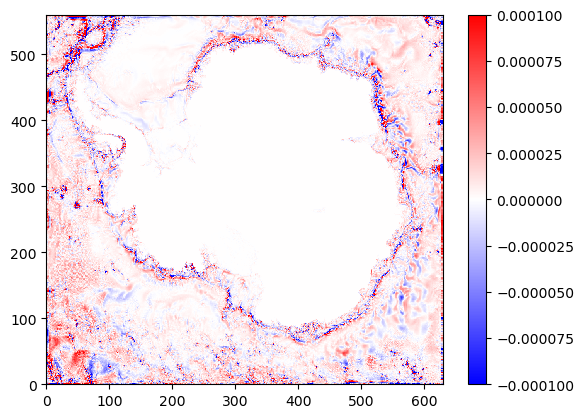

In [12]:
plt.pcolor(temp_hadv_dz.sum('s_rho').mean('ocean_time'), cmap='bwr', vmin=-0.0001, vmax=0.0001)
plt.colorbar()

In [13]:
files_path = '/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/'


In [14]:
contour_masked_above = np.load(files_path + 'WAOM10_contour_masked_above_1500m_v3', allow_pickle=True)
contour_masked_above_CF = np.load(files_path + 'WAOM10_contour_masked_above_CF_v3', allow_pickle=True)


### continue original script:

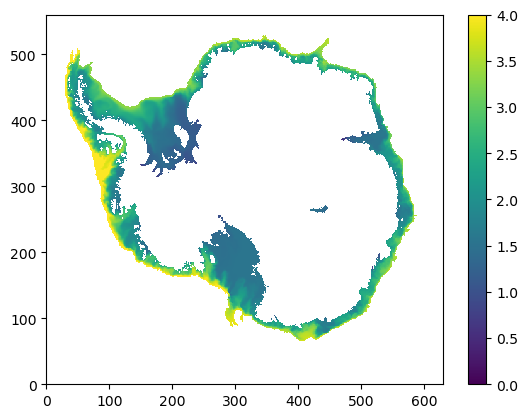

In [15]:
Tf = -3.55
plt.pcolormesh(ma.masked_where(contour_masked_above == -1000, temp.isel(s_rho=0).mean('ocean_time')-Tf), vmin=0, vmax=4)
plt.colorbar()

In [16]:
%%time

ds = xr.open_mfdataset(paths="/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_20yr_diag_daily/ocean_his_00*.nc" , chunks={'eta_rho': '200MB'}, parallel=bool, decode_times=False) #, chuncks="auto", concat_dim="ocean_time"

#- preserving 5-days avgs
temp_snap = ds.variables["temp"] ##+273.15 (changing to Kelvin didn't change any results)
time_snap = ds.variables["ocean_time"]
ds.close()


CPU times: user 19.7 s, sys: 3.76 s, total: 23.5 s
Wall time: 38.7 s


In [17]:
%%time

# calculate dT/dt by differentiating temp_snap:
temp_Rate = np.empty(temp_snap.shape)
dT = np.empty(temp_snap.shape)

# needs the initial conditions:
ds = xr.open_dataset('/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_11-20yr/ocean_rst.nc')
temp_ini = ds.variables["temp"].isel(ocean_time=8, two=0) ##+273.15 (changing to Kelvin didn't change any results) # 5-days mean
time_ini = ds.variables["ocean_time"].isel(ocean_time=8)
ds.close()

    
tlen = len(temp[:,0,0,0])

CPU times: user 153 ms, sys: 45.1 ms, total: 198 ms
Wall time: 335 ms


In [18]:
%%time

# transform to DataArray
temp_snap = xr.DataArray(temp_snap)
temp_ini = xr.DataArray(temp_ini)

# - append temp_ini to first time index in temp_snap and then do diff
temp_snap = xr.concat([temp_ini,temp_snap], 'ocean_time')
dT = temp_snap.diff('ocean_time')
print(dT.shape)

# 
# dt = 5*86400 # 5-days in seconds
dt = 86400 # 1day
temp_Rate = np.divide(dT, dt)
temp_Rate = xr.DataArray(temp_Rate)
# temp_Rate=temp_Rate.rename({'dim_0':'ocean_time','dim_1':'s_rho','dim_2':'eta_rho','dim_3':'xi_rho'})

print(dT.shape)

temp_Rate = temp_Rate.transpose('ocean_time','s_rho','eta_rho','xi_rho')

print(temp_Rate.shape)

(31, 560, 630, 365)
(31, 560, 630, 365)
(365, 31, 560, 630)
CPU times: user 248 ms, sys: 154 ms, total: 402 ms
Wall time: 605 ms


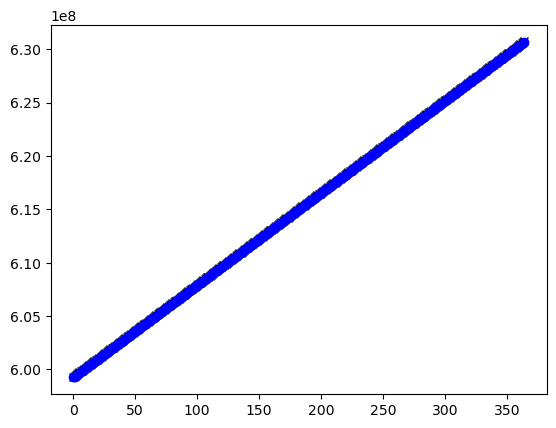

In [19]:
# check time stamps across his/avg variables to make sure they match:


# # print('1.', time_snap)
# print('2.', 2007+(time_snap[0]/86400/365))
# print('3.', time_ini)
# time_ini_datenum = (np.datetime64('2025-12-27')-np.datetime64('2007-01-01'))
# print('4.', time_ini_datenum/365, ', NOT days, years!')
# print('5.', (599616000-599184000)/86400) # 5-days!

# time_snap_np = time_snap.values
# time_ini_np = time_ini.values
# print(time_ini, time_snap_np.shape)
# time_snap2 = np.concatenate((time_ini_np,time_snap_np), axis=0)
# print(time_snap2.shape)

# # transform to DataArray
# time_snap = xr.DataArray(time_snap)
# time_ini = xr.DataArray(time_ini)

# print(time_snap.shape, time_ini.shape)

# # - append temp_ini to first time index in temp_snap and then do diff
# time_snap2 = xr.concat([time_ini,time_snap], 'ocean_time')

# print(time_snap2.shape, time_avg.shape)

plt.plot(np.arange(0,365),time_snap,'xk')
plt.plot(np.arange(0,365),time_avg,'ob')
# plt.plot(np.arange(0,365),time_snap2,'.r')
# plt.xlim(0,5)


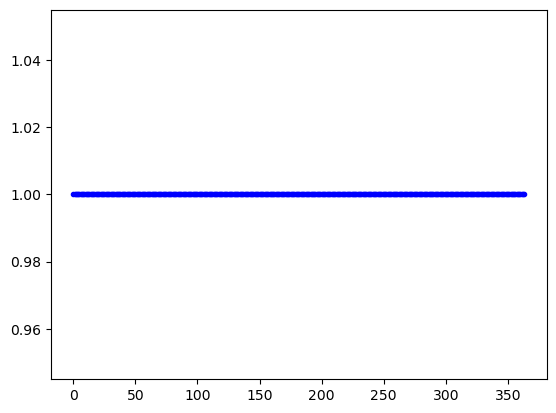

In [20]:
# calculate dt for avg/his timestamps:

dt_avg = np.diff(time_avg)
dt_snap = np.diff(time_snap)

plt.plot(np.arange(0,364),dt_avg/86400,'.b')

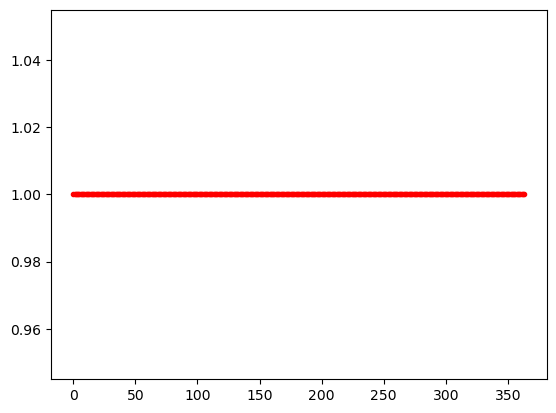

In [21]:
plt.plot(np.arange(0,364),dt_snap/86400,'.r')


In [22]:
# determine constants:
# rho0 = 1025 # kg. m-3
# Cp = 3989.245 # J.kg-1.degC-1
# Tf = -1.95 # degC
# use same value as ACCESS-OM2
rho0=1035
Cp=3992.1
# Tf = -1.95 # degC
Tf =  -3.534879684448242

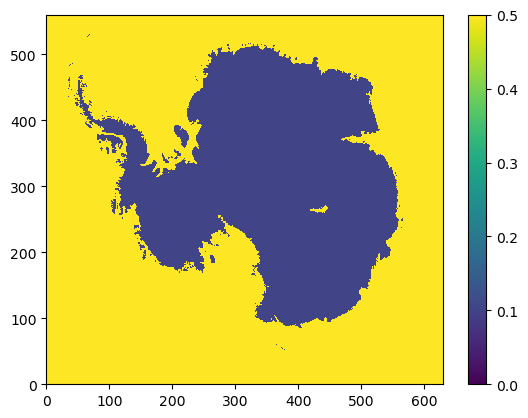

In [23]:
plt.pcolormesh(h-abs(zice), vmin=0, vmax=0.5)
plt.colorbar()

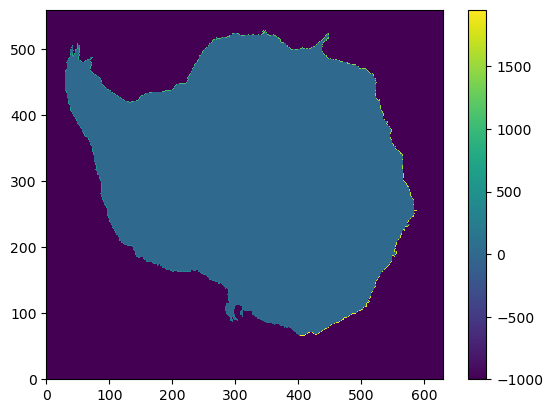

In [24]:
plt.pcolormesh(contour_masked_above)#, vmin=0, vmax=1)
plt.colorbar()

In [26]:
# Define conditions to mask out (1) off the shelf, (2) land (see plots above)
condition1 = contour_masked_above == -1000
condition2 = (zice+h) <= 1

# Combine conditions with logical OR
combined_condition = condition1 | condition2


In [27]:
%%time

# use -1000 mask to compute integral of surface heat fluxes and ocean heat content tendency:
# temp_Rate=xr.DataArray(temp_Rate)
temp_rate = temp_Rate.transpose('ocean_time','s_rho','eta_rho','xi_rho')
dT = dT.transpose('ocean_time','s_rho','eta_rho','xi_rho')

## Integrated heat tendency and sfc heat flux terms to check heat budget closure*1
# 1. area-integral surface heat flux
tlen = len(temp_rate[:,0,0,0])
area_sum =  np.nansum(np.nansum(area,axis=1), axis=0)

shflux_int = np.empty((tlen))
for mm in np.arange(0,tlen):
    shflux_masked = ma.masked_where(combined_condition, shflux[mm,:]) # -1000 is just the mask for values south of 1500m isobath; not depths.
    shflux_area = shflux_masked*area
    shflux_int[mm] = np.nansum(np.nansum(shflux_area,axis=1), axis=0)
    #del shflux_area
    
# 2. volume-integral heat tendency
temp_rate_int = np.empty((tlen))
temp_rate_vol = np.empty(np.squeeze(temp_Rate[:,0,:,:]).shape)
for mm in np.arange(0,tlen):
# - multplying by dz:
    temp_rate_dz = temp_Rate[mm,:]*dz[mm,:]
    temp_rate_vint = np.nansum(temp_rate_dz, axis=0)
    temp_rate_vint_masked =  ma.masked_where(combined_condition, temp_rate_vint)
    temp_rate_vol[mm,:] = temp_rate_vint_masked*area
    
    #del temp_rate_vint
    temp_rate_int[mm] = np.nansum(np.nansum(temp_rate_vol[mm,:],axis=1), axis=0)*Cp*rho0


CPU times: user 5min 3s, sys: 3min 15s, total: 8min 19s
Wall time: 14min 45s


In [28]:
# temp_Rate.load()
temp_hadv.load()
temp_vadv.load()
temp_hdiff.load()
temp_vdiff.load()
# temp_sdiff.load()

<xarray.Variable (ocean_time: 365, s_rho: 31, eta_rho: 560, xi_rho: 630)> Size: 16GB
array([[[[ 5.01010844e-10,  5.01010844e-10,  2.71233214e-09, ...,
           3.91122912e-09,  3.47094797e-09,  3.47094797e-09],
         [ 5.01010844e-10,  5.01010844e-10,  2.71233214e-09, ...,
           3.91122912e-09,  3.47094797e-09,  3.47094797e-09],
         [ 1.42418529e-07,  1.42418529e-07,  7.19037319e-09, ...,
           2.80613399e-09,  3.00310754e-09,  3.00310754e-09],
         ...,
         [-2.37307916e-08, -2.37307916e-08,  5.07452924e-09, ...,
          -7.99333399e-09, -7.13377375e-08, -7.13377375e-08],
         [ 4.37686367e-08,  4.37686367e-08,  5.55084334e-09, ...,
          -4.09366869e-08, -3.97770435e-07, -3.97770435e-07],
         [ 4.37686367e-08,  4.37686367e-08,  5.55084334e-09, ...,
          -4.09366869e-08, -3.97770435e-07, -3.97770435e-07]],

        [[ 2.78256462e-09,  2.78256462e-09,  1.89759275e-09, ...,
           4.07766182e-10,  6.35927588e-10,  6.35927588e-10],
         [ 2.78256462e-09,  2.78256462e-09,  1.89759275e-09, ...,
           4.07766182e-10,  6.35927588e-10,  6.35927588e-10],
         [-1.08962659e-07, -1.08962659e-07, -1.39757117e-09, ...,
           2.56029815e-11, -5.04370046e-10, -5.04370046e-10],
...
           1.21216078e-06,  4.18174665e-07,  4.18174665e-07],
         [ 9.80847972e-08,  9.80847972e-08,  3.90833236e-07, ...,
           7.52034396e-07,  1.04000996e-07,  1.04000996e-07],
         [ 9.80847972e-08,  9.80847972e-08,  3.90833236e-07, ...,
           7.52034396e-07,  1.04000996e-07,  1.04000996e-07]],

        [[ 5.41950840e-07,  5.41950840e-07,  8.90026740e-07, ...,
          -1.51472094e-07,  1.34805632e-07,  1.34805632e-07],
         [ 5.41950840e-07,  5.41950840e-07,  8.90026740e-07, ...,
          -1.51472094e-07,  1.34805632e-07,  1.34805632e-07],
         [-7.40270778e-08, -7.40270778e-08,  8.42176576e-07, ...,
          -1.48600100e-06,  2.40991852e-07,  2.40991852e-07],
         ...,
         [ 1.20662651e-06,  1.20662651e-06,  1.10778547e-06, ...,
          -3.55676275e-06,  4.44675152e-06,  4.44675152e-06],
         [ 1.32464436e-06,  1.32464436e-06,  8.69604264e-07, ...,
          -1.77187769e-06,  3.41823636e-07,  3.41823636e-07],
         [ 1.32464436e-06,  1.32464436e-06,  8.69604264e-07, ...,
          -1.77187769e-06,  3.41823636e-07,  3.41823636e-07]]]],
      dtype=float32)
Attributes:
    long_name:  potential temperature, vertical diffusion term
    units:      Celsius second-1
    time:       ocean_time
    field:      temp_vdiff, scalar, series

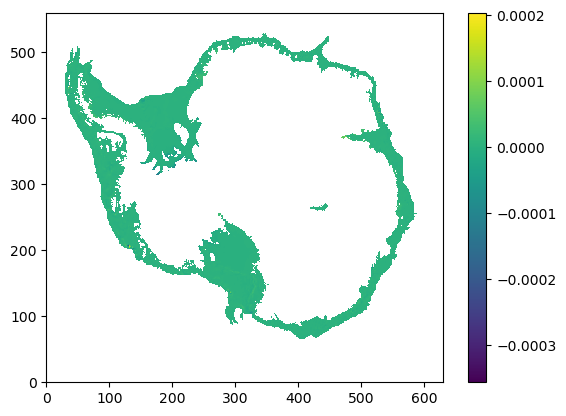

In [29]:
# define sum of all RHS:
RHS_budget = temp_hadv + temp_vadv + temp_hdiff + temp_vdiff
RHS_budget_masked = ma.masked_where(combined_condition, RHS_budget.sum('s_rho').isel(ocean_time=0))

plt.pcolormesh(RHS_budget_masked)#, vmin=-1e-12, vmax=1e-12, cmap='coolwarm')
plt.colorbar()

In [30]:
%%time
# integral with all RHS terms (as suggested by Wilkin)
RHS_budget_int = np.empty((tlen))
RHS_budget_vol = np.empty(np.squeeze(RHS_budget[:,0,:,:]).shape)
for mm in np.arange(0,tlen):
# - multplying by dz:
    RHS_budget_dz = RHS_budget[mm,:]*dz[mm,:]
    RHS_budget_vint = np.nansum(RHS_budget_dz, axis=0)
    RHS_budget_vint_masked =  ma.masked_where(combined_condition, RHS_budget_vint)
    RHS_budget_vol[mm,:] = RHS_budget_vint_masked*area
    RHS_budget_int[mm] = np.nansum(np.nansum(RHS_budget_vol[mm,:],axis=1), axis=0)*Cp*rho0


CPU times: user 31.8 s, sys: 17.1 s, total: 48.9 s
Wall time: 39.8 s


In [31]:
%%time
# 3. heat tendency due to horizontal diffusion:
temp_hdiff_int = np.empty((tlen))
temp_hdiff_vol = np.empty(np.squeeze(temp_hdiff[:,0,:,:]).shape)
for mm in np.arange(0,tlen):
# - multplying by dz:
    temp_hdiff_dz = temp_hdiff[mm,:]*dz[mm,:]
    temp_hdiff_vint = np.nansum(temp_hdiff_dz, axis=0)
    temp_hdiff_vint_masked =  ma.masked_where(combined_condition, temp_hdiff_vint)
    temp_hdiff_vol[mm,:] = temp_hdiff_vint_masked*area
    temp_hdiff_int[mm] = np.nansum(np.nansum(temp_hdiff_vol[mm,:],axis=1), axis=0)*Cp*rho0


CPU times: user 31.7 s, sys: 17.1 s, total: 48.8 s
Wall time: 39.7 s


In [32]:
%%time
# 4. heat tendency due to horizontal advection:
temp_hadv_int = np.empty((tlen))
temp_hadv_vol = np.empty(np.squeeze(temp_hadv[:,0,:,:]).shape)
for mm in np.arange(0,tlen):
# - multplying by dz:
    temp_hadv_dz = temp_hadv[mm,:]*dz[mm,:]
    temp_hadv_vint = np.nansum(temp_hadv_dz, axis=0)
    temp_hadv_vint_masked =  ma.masked_where(combined_condition, temp_hadv_vint)
    temp_hadv_vol[mm,:] = temp_hadv_vint_masked*area
    temp_hadv_int[mm] = np.nansum(np.nansum(temp_hadv_vol[mm,:],axis=1), axis=0)*Cp*rho0


CPU times: user 31.4 s, sys: 17.1 s, total: 48.4 s
Wall time: 39.5 s


In [33]:
%%time
# 5. heat tendency due to vertical advection:
temp_vadv_int = np.empty((tlen))
temp_vadv_vol = np.empty(np.squeeze(temp_vadv[:,0,:,:]).shape)
for mm in np.arange(0,tlen):
# - multplying by dz:
    temp_vadv_dz = temp_vadv[mm,:]*dz[mm,:]
    temp_vadv_vint = np.nansum(temp_vadv_dz, axis=0)
    temp_vadv_vint_masked =  ma.masked_where(combined_condition, temp_vadv_vint)
    temp_vadv_vol[mm,:] = temp_vadv_vint_masked*area
    temp_vadv_int[mm] = np.nansum(np.nansum(temp_vadv_vol[mm,:],axis=1), axis=0)*Cp*rho0


CPU times: user 31.8 s, sys: 17.3 s, total: 49.1 s
Wall time: 40 s


In [34]:
%%time
# 6. heat tendency due to vertical diffusion (should be equal to the sfc heat flux)
temp_vdiff_int = np.empty((tlen))
temp_vdiff_vol = np.empty(np.squeeze(temp_vdiff[:,0,:,:]).shape)
for mm in np.arange(0,tlen):
# - multplying by dz:
    temp_vdiff_dz = temp_vdiff[mm,:]*dz[mm,:]
    temp_vdiff_vint = np.nansum(temp_vdiff_dz, axis=0)
    temp_vdiff_vint_masked =  ma.masked_where(combined_condition, temp_vdiff_vint) # I think I can remove the first masking, no need to repeat it.
    temp_vdiff_vol[mm,:] = temp_vdiff_vint_masked*area
    temp_vdiff_int[mm] = np.nansum(np.nansum(temp_vdiff_vol[mm,:],axis=1), axis=0)*Cp*rho0


CPU times: user 31.9 s, sys: 17.2 s, total: 49 s
Wall time: 40 s


In [35]:
# %%time
# # 7. heat tendency due to rotated diffusion (should be equal to the sfc heat flux)
# temp_sdiff_int = np.empty((tlen))
# temp_sdiff_vol = np.empty(np.squeeze(temp_sdiff[:,0,:,:]).shape)
# for mm in np.arange(0,tlen):
# # - multplying by dz:
#     temp_sdiff_dz = temp_sdiff[mm,:]*dz[mm,:]
#     temp_sdiff_vint = np.nansum(temp_sdiff_dz, axis=0)
#     temp_sdiff_vint_masked =  ma.masked_where(combined_condition, temp_sdiff_vint) # I think I can remove the first masking, no need to repeat it.
#     temp_sdiff_vol[mm,:] = temp_sdiff_vint_masked*area
#     temp_sdiff_int[mm] = np.nansum(np.nansum(temp_sdiff_vol[mm,:],axis=1), axis=0)*Cp*rho0


In [36]:
temp_hdiff_vol.shape

(365, 560, 630)

In [37]:
# calculate horizontal-integrated area:
area_masked = ma.masked_where(contour_masked_above == -1000, area)
area_sum = np.nansum(np.nansum(area_masked,axis=1), axis=0)

print(area_sum*1e-15)

0.017003058867057424


In [38]:
### JUST DOUBLE CHECK todays earlier/late afternoon calculatin with v3 contour_mask_above

# calculate horizontal-integrated area:
area_masked = ma.masked_where(contour_masked_above == -1000, area)
area_sum = np.nansum(np.nansum(area_masked,axis=1), axis=0)

print(area_sum*1e-15)

0.017003058867057424


In [39]:
print(temp_Rate.shape, dz.shape)

(365, 31, 560, 630) (365, 31, 560, 630)


In [40]:
print(shflux_area.shape, shflux_int.shape)
print(np.mean(shflux_int))#/area_sum)

(560, 630) (365,)
-67638951241634.61


In [41]:
print(temp_rate_vol.shape, temp_rate_int.shape)
print(np.mean(temp_rate_int))#/area_sum)

(365, 560, 630) (365,)
1136006435357.245


In [42]:
temp_rate_vol.shape

(365, 560, 630)

Text(0.5, 1.0, 'vert adv')

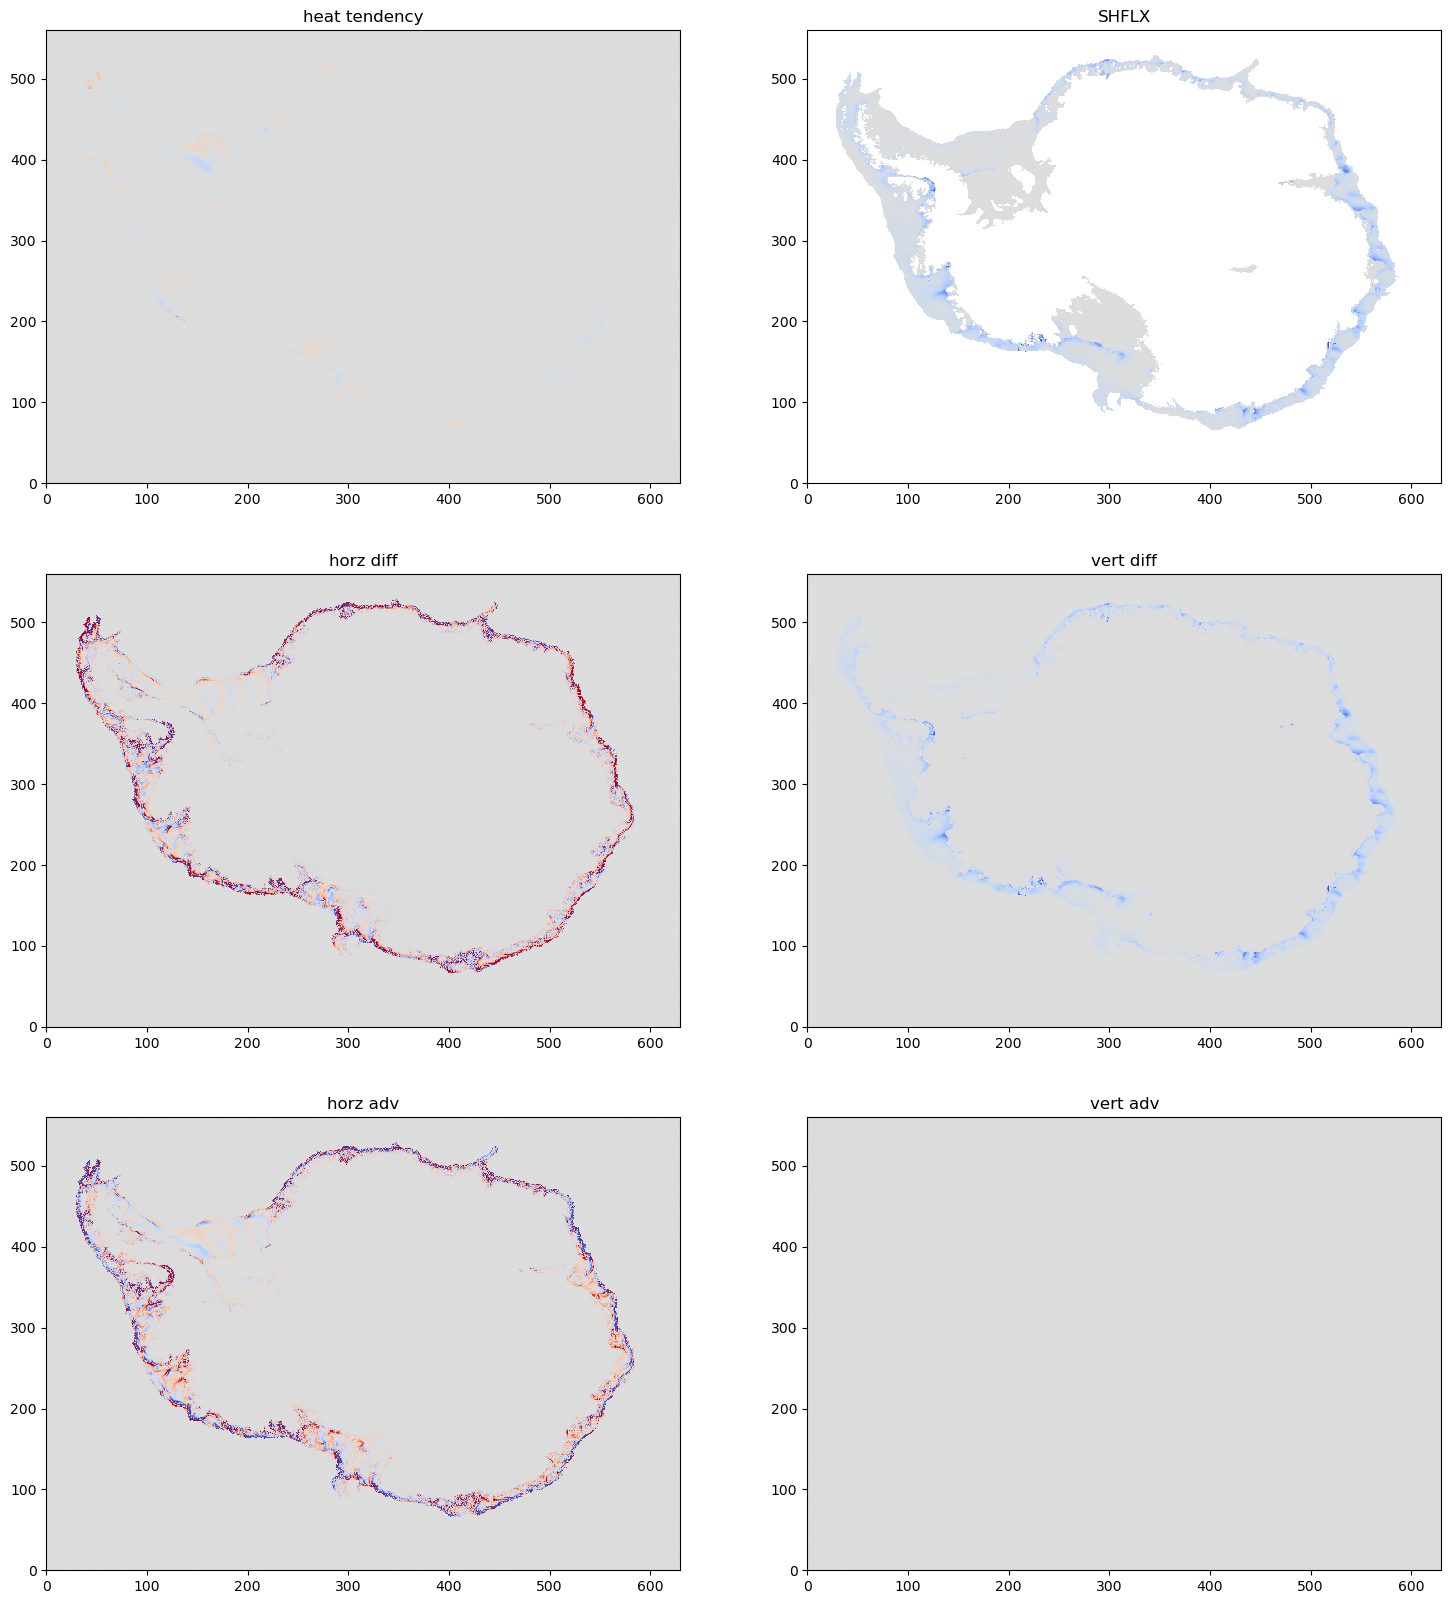

In [43]:
mm=35

# call cartopy projection
proj = ccrs.PlateCarree(central_longitude=-24)
fig = plt.figure(figsize=(18,20))

ax1 = fig.add_subplot(321)
aa=ax1.pcolormesh(np.nanmean(temp_rate_vol, axis=0), vmin=-.5e4, vmax=.5e4, cmap='coolwarm')
ax1.set_title('heat tendency')

ax2 = fig.add_subplot(322)
ax2.pcolormesh(ma.masked_where(contour_masked_above == -1000, np.nanmean(shflux,axis=0)*(area/(Cp*rho0))), vmin=-.5e4, vmax=.5e4, cmap='coolwarm')
ax2.set_title('SHFLX')

ax3 = fig.add_subplot(323)
ax3.pcolormesh(np.nanmean(temp_hdiff_vol,axis=0), vmin=-.5e4, vmax=.5e4, cmap='coolwarm')
ax3.set_title('horz diff')

ax4 = fig.add_subplot(324)
ax4.pcolormesh(np.nanmean(temp_vdiff_vol,axis=0), vmin=-.5e4, vmax=.5e4, cmap='coolwarm')
ax4.set_title('vert diff')

ax5 = fig.add_subplot(325)
ax5.pcolormesh(np.nanmean(temp_hadv_vol,axis=0), vmin=-.5e4, vmax=.5e4, cmap='coolwarm')
ax5.set_title('horz adv')

ax6 = fig.add_subplot(326)
ax6.pcolormesh(np.nanmean(temp_vadv_vol,axis=0), vmin=-.5e4, vmax=.5e4, cmap='coolwarm')
ax6.set_title('vert adv')




# make a nice figure with the v-integrated heat flux convergence maps:

In [44]:
# load 1500 and calving front contours:

tmp_files_dir = '/g/data3/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/'
expt = 'WAOM10'
ds = xr.open_dataset(tmp_files_dir + expt + '_lon_along_1500m')
lon_along_10km_shelf = ds.variables["one"]
ds.close()
ds = xr.open_dataset(tmp_files_dir + expt + '_lat_along_1500m')
lat_along_10km_shelf = ds.variables["two"]
ds.close()
ds = xr.open_dataset(tmp_files_dir + expt + '_lon_along_CalvingFront')
lon_along_10km_CF = ds.variables["one"]
ds.close()
ds = xr.open_dataset(tmp_files_dir + expt + '_lat_along_CalvingFront')
lat_along_10km_CF = ds.variables["two"]
ds.close()

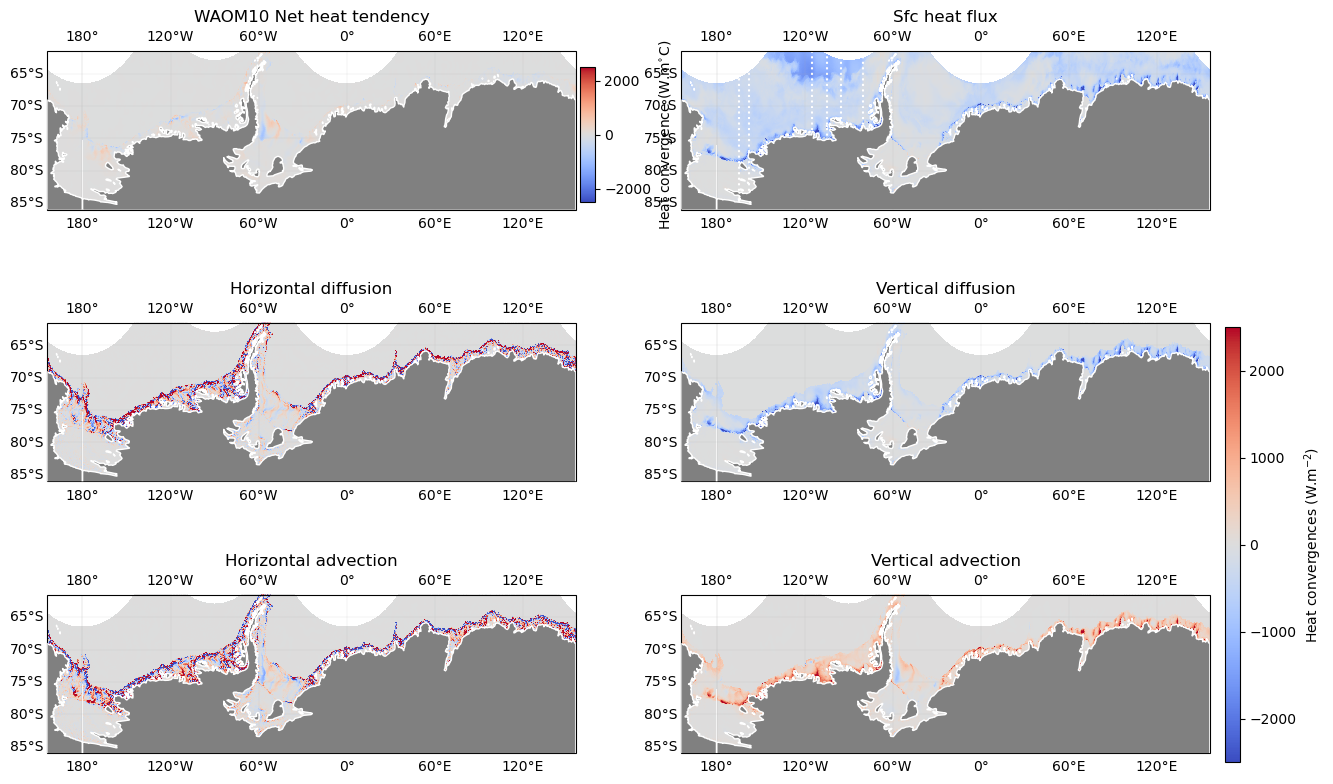

In [60]:
# Fig 1 - paper (WAOM10)
# --- bottom T
jst= 41
jen=-1
ist=0
ien=-1

tmin = -2.7
tmax = 1
atmin = -1
atmax = 1

# define cross-section vectors:
lat_maxpts = np.ceil(30/0.091985) # took 3.5min
lon=-115 
lon_vector_115 = np.linspace(lon,lon,num=int(lat_maxpts))  # replace 0 -> lon_bin looping
lon=-110 
lon_vector_110 = np.linspace(lon,lon,num=int(lat_maxpts))  # replace 0 -> lon_bin looping
lon=-105
lon_vector_105 = np.linspace(lon,lon,num=int(lat_maxpts))  # replace 0 -> lon_bin looping
lon=-80
lon_vector_80 = np.linspace(lon,lon,num=int(lat_maxpts))  # replace 0 -> lon_bin looping
lon=-85
lon_vector_85 = np.linspace(lon,lon,num=int(lat_maxpts))  # replace 0 -> lon_bin looping
lon=-95
lon_vector_95 = np.linspace(lon,lon,num=int(lat_maxpts))  # replace 0 -> lon_bin looping
lon=-158
lon_vector_158 = np.linspace(lon,lon,num=int(lat_maxpts))  # replace 0 -> lon_bin looping
lon=-160
lon_vector_160 = np.linspace(lon,lon,num=int(lat_maxpts))  # replace 0 -> lon_bin looping
lon=-165
lon_vector_165 = np.linspace(lon,lon,num=int(lat_maxpts))  # replace 0 -> lon_bin looping
minlat = -90
maxlat = -60
lat_vector = np.linspace(minlat,maxlat,num=int(lat_maxpts))

# call cartopy projection
proj = ccrs.PlateCarree(central_longitude=-24)
fig = plt.figure(figsize=(15,10))

# Net heat tendency
ax1 = fig.add_subplot(321, projection=proj)
ct1=plt.pcolormesh(lon_rho[jst:jen,ist:ien].values,lat_rho[jst:jen,ist:ien].values,
                  np.nanmean(temp_rate_vol[:,jst:jen,ist:ien], axis=0), transform=ccrs.PlateCarree(), vmin=-2.5e3, vmax=2.5e3, cmap='coolwarm')
# plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=.8, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
# plt.scatter(lon_along_10km_shelf,lat_along_10km_shelf, s=.8, alpha=0.4, color='lightgreen',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('WAOM10 Net heat tendency')

ax1.gridlines(draw_labels=True,linewidth=.1)
ax1.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
# plt.colorbar(ct1, location="right")
ax1.set_extent([-180-24, 155, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax1.get_xlim()
y_low, y_high = ax1.get_ylim()
ratio = .3
ax1.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

cbar_ax0 = fig.add_axes([0.48, 0.695, 0.01, 0.135])
fig.colorbar(ct1, cax=cbar_ax0, orientation='vertical')
cbar_ax0.set_ylabel('Heat convergence (W.m$^{\circ}$C)')#, labelpad=-35)

# sfc hflux
ax2 = fig.add_subplot(322, projection=proj)
ct1=plt.pcolormesh(lon_rho[jst:jen,ist:ien].values,lat_rho[jst:jen,ist:ien].values,
                   np.nanmean(shflux[:,jst:jen,ist:ien],axis=0)*
                                  (area[jst:jen,ist:ien]/(Cp*rho0)), transform=ccrs.PlateCarree(), vmin=-2.5e3, vmax=2.5e3, cmap='coolwarm')

                  # ma.masked_where(contour_masked_above[jst:jen,ist:ien] == -1000, np.nanmean(shflux[:,jst:jen,ist:ien],axis=0)*
                  #                 (area[jst:jen,ist:ien]/(Cp*rho0))), vmin=-2.5e3, vmax=2.5e3, cmap='coolwarm')

# plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=.8, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
# plt.scatter(lon_along_10km_shelf,lat_along_10km_shelf, s=.8, alpha=0.4, color='lightgreen',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('Sfc heat flux')
plt.plot(lon_vector_115,lat_vector, ':w', transform=ccrs.PlateCarree())
plt.plot(lon_vector_105,lat_vector, ':w', transform=ccrs.PlateCarree())
plt.plot(lon_vector_80,lat_vector, ':w', transform=ccrs.PlateCarree())
plt.plot(lon_vector_95,lat_vector, ':w', transform=ccrs.PlateCarree())
plt.plot(lon_vector_158,lat_vector, ':w', transform=ccrs.PlateCarree())
plt.plot(lon_vector_165,lat_vector, ':w', transform=ccrs.PlateCarree())
ax2.gridlines(draw_labels=True,linewidth=.1)
ax2.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
ax2.set_extent([-180-24, 155, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax2.get_xlim()
y_low, y_high = ax2.get_ylim()
ratio = .3
ax2.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# horz diffusion
ax3 = fig.add_subplot(323, projection=proj)
ct1=plt.pcolormesh(lon_rho[jst:jen,ist:ien].values,lat_rho[jst:jen,ist:ien].values,
                  np.nanmean(temp_hdiff_vol[:,jst:jen,ist:ien],axis=0), transform=ccrs.PlateCarree(), vmin=-2.5e3, vmax=2.5e3, cmap='coolwarm')

# plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=.8, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
# plt.scatter(lon_along_10km_shelf,lat_along_10km_shelf, s=.8, alpha=0.4, color='lightgreen',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('Horizontal diffusion')

ax3.gridlines(draw_labels=True,linewidth=.1)
ax3.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
ax3.set_extent([-180-24, 155, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax3.get_xlim()
y_low, y_high = ax3.get_ylim()
ratio = .3
ax3.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# vert diffusion
ax4 = fig.add_subplot(324, projection=proj)
ct1=plt.pcolormesh(lon_rho[jst:jen,ist:ien].values,lat_rho[jst:jen,ist:ien].values,
                  np.nanmean(temp_vdiff_vol[:,jst:jen,ist:ien],axis=0), transform=ccrs.PlateCarree(), vmin=-2.5e3, vmax=2.5e3, cmap='coolwarm')

# plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=.8, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
# plt.scatter(lon_along_10km_shelf,lat_along_10km_shelf, s=.8, alpha=0.4, color='lightgreen',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('Vertical diffusion')

ax4.gridlines(draw_labels=True,linewidth=.1)
ax4.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
ax4.set_extent([-180-24, 155, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax4.get_xlim()
y_low, y_high = ax4.get_ylim()
ratio = .3
ax4.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# horz adv
ax5 = fig.add_subplot(325, projection=proj)
ct1=plt.pcolormesh(lon_rho[jst:jen,ist:ien].values,lat_rho[jst:jen,ist:ien].values,
                  np.nanmean(temp_hadv_vol[:,jst:jen,ist:ien],axis=0), transform=ccrs.PlateCarree(), vmin=-2.5e3, vmax=2.5e3, cmap='coolwarm')

# plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=.8, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
# plt.scatter(lon_along_10km_shelf,lat_along_10km_shelf, s=.8, alpha=0.4, color='lightgreen',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('Horizontal advection')

ax5.gridlines(draw_labels=True,linewidth=.1)
ax5.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
ax5.set_extent([-180-24, 155, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax5.get_xlim()
y_low, y_high = ax5.get_ylim()
ratio = .3
ax5.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# vert adv
ax6 = fig.add_subplot(326, projection=proj)
ct1=plt.pcolormesh(lon_rho[jst:jen,ist:ien].values,lat_rho[jst:jen,ist:ien].values,
                    np.nanmean(temp_hadv_vol[:,jst:jen,ist:ien],axis=0) +
                    np.nanmean(temp_hdiff_vol[:,jst:jen,ist:ien],axis=0)
                    , transform=ccrs.PlateCarree(), vmin=-2.5e3, vmax=2.5e3, cmap='coolwarm')

# plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=.8, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
# plt.scatter(lon_along_10km_shelf,lat_along_10km_shelf, s=.8, alpha=0.4, color='lightgreen',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('Vertical advection')

ax6.gridlines(draw_labels=True,linewidth=.1)
ax6.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
ax6.set_extent([-180-24, 155, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax5.get_xlim()
y_low, y_high = ax5.get_ylim()
ratio = .3
ax6.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

cbar_ax1 = fig.add_axes([0.91, 0.135, 0.01, 0.435])
fig.colorbar(ct1, cax=cbar_ax1, orientation='vertical')
cbar_ax1.set_ylabel('Heat convergences (W.m$^{-2}$)')#, labelpad=-35)


name_fig='waom10extend_OHBsouth1500m_vint_maps_yr20.png'
plt.savefig(fig_path + name_fig, dpi=300, bbox_inches='tight')


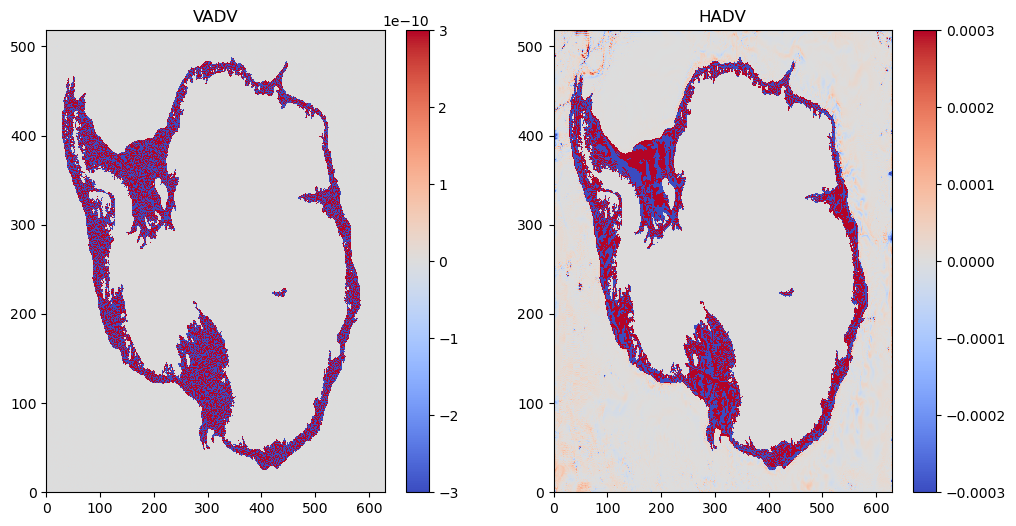

In [52]:
## looking at VADV:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(121)
ct1=plt.pcolormesh(np.nanmean(temp_vadv_vol[:,jst:jen,ist:ien],axis=0), vmin=-3e-10, vmax=3e-10, cmap='coolwarm')
plt.colorbar()
plt.title('VADV')
#
ax2 = fig.add_subplot(122)
ct1=plt.pcolormesh(np.nanmean(temp_hadv_vol[:,jst:jen,ist:ien],axis=0), vmin=-3e-4, vmax=3e-4, cmap='coolwarm')
# plt.colorbar()
plt.title('HADV')
plt.colorbar()


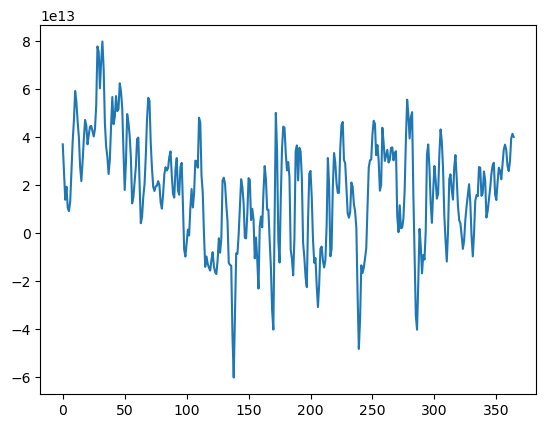

In [47]:
plt.plot(temp_hadv_int*1/(rho0*Cp()

In [48]:
rho0*Cp*1e-6


4.131823499999999

In [49]:
# OHB integrated
print('OHC tendency annual avg (TW): ',np.nanmean(temp_rate_int)*1e-12)
# print(np.mean(temp_rate2_int)*1e-15)
print('Net sfc heat flux annual avg (TW): ',np.nanmean(shflux_int)*1e-12)
print('Residue (OHC - shflux) (TW): ',(np.nanmean(temp_rate_int)-np.nanmean(shflux_int))*1e-12)
print('Horz. diffusion (TW): ',np.nanmean(temp_hdiff_int)*1e-12)
print('Vert. diffusion (TW): ',np.nanmean(temp_vdiff_int)*1e-12)
# print('Isop. diffusion (TW): ',np.nanmean(temp_sdiff_int)*1e-12)
print('Horz. advection (TW): ',np.nanmean(temp_hadv_int)*1e-12)
print('Vert. advection (TW): ',np.nanmean(temp_vadv_int)*1e-12)
print('Sum all above terms: ',np.nanmean(temp_hadv_int + temp_vadv_int + temp_hdiff_int + temp_vdiff_int)*1e-12)
print('Sum all RHS terms: ',np.nanmean(RHS_budget_int)*1e-12)

OHC tendency annual avg (TW):  1.136006435357245
Net sfc heat flux annual avg (TW):  -67.63895124163462
Residue (OHC - shflux) (TW):  68.77495767699185
Horz. diffusion (TW):  51.79160023931157
Vert. diffusion (TW):  -68.28727768784402
Horz. advection (TW):  17.62343653550491
Vert. advection (TW):  -2.7245011860574814e-09
Sum all above terms:  1.1277590842479466
Sum all RHS terms:  1.1277590693782795


In [55]:
# OHB integrated, sum over 1year:
print('OHC tendency annual avg (TW): ',np.nansum(temp_rate_int)*1e-12)
# print(np.mean(temp_rate2_int)*1e-15)
print('Net sfc heat flux annual avg (TW): ',np.nansum(shflux_int)*1e-12)
print('Horz. diffusion (TW): ',np.nansum(temp_hdiff_int)*1e-12)
print('Vert. diffusion (TW): ',np.nansum(temp_vdiff_int)*1e-12)
# print('Isop. diffusion (TW): ',np.nansum(temp_sdiff_int)*1e-12)
print('Horz. advection (TW): ',np.nansum(temp_hadv_int)*1e-12)
print('Vert. advection (TW): ',np.nansum(temp_vadv_int)*1e-12)
print('Sum all above terms: ',np.nansum(temp_hadv_int + temp_vadv_int + temp_hdiff_int + temp_vdiff_int)*1e-12)
print('Sum all RHS terms: ',np.nansum(RHS_budget_int)*1e-12)

OHC tendency annual avg (TW):  414.6423489053945
Net sfc heat flux annual avg (TW):  -24688.217203196633
Horz. diffusion (TW):  18903.934087348724
Vert. diffusion (TW):  -24924.856356063072
Horz. advection (TW):  6432.554335459292
Vert. advection (TW):  -9.944429329109806e-07
Sum all above terms:  411.6320657505005
Sum all RHS terms:  411.632060323072


In [56]:
print('Vert. advection (TW): ',np.nansum(temp_vadv_int)*1e-12)
print('Sum all above terms (incl. vert. adv): ',np.sum(temp_rate_int + shflux_int + temp_hdiff_int + temp_hadv_int)*1e-12)


Vert. advection (TW):  -9.944429329109806e-07
Sum all above terms (incl. vert. adv):  1062.913568516771


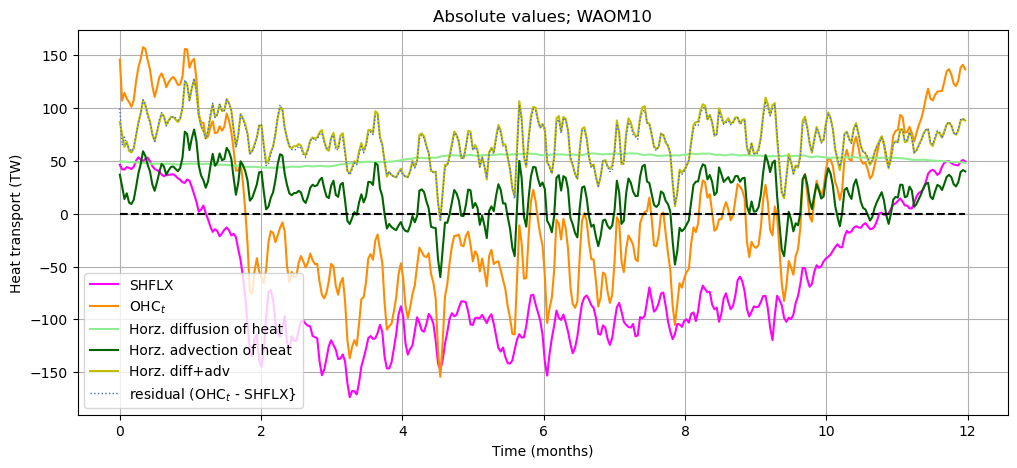

In [59]:
##### months=np.arange(0,365)*(1/30.41667)
all_rhs = temp_hdiff_int + temp_vdiff_int + temp_hadv_int + temp_vadv_int

fig, ax = plt.subplots(figsize = (12, 5))
plt.plot(months,np.divide(shflux_int,1)*1e-12, label='SHFLX', color='magenta')
plt.plot(months,np.divide(temp_rate_int,1)*1e-12, label='OHC$_{t}$', color='darkorange')
plt.plot(months,temp_hdiff_int*1e-12, label='Horz. diffusion of heat', color='lightgreen')
# plt.plot(months,temp_vdiff_int, label='Vert. diffusion of heat', color='darkgreen')
plt.plot(months,temp_hadv_int*1e-12, label='Horz. advection of heat',color='darkgreen')
# plt.plot(months,temp_vadv_int, label='Vert. advection of heat',color='darkblue')
# plt.plot(months,RHS_budget_int - shflux_int, label='RHS - SHFLX',color='y')
plt.plot(months,(temp_hdiff_int + temp_hadv_int)*1e-12, label='Horz. diff+adv',color='y')

plt.plot(months,shflux_int*0,'--k')
plt.plot(months,(temp_rate_int - shflux_int)*1e-12, ':r', label='residual (OHC$_{t}$ - SHFLX}',linewidth=1, color='royalblue')
# plt.plot(months,temp_hadv_int + temp_hdiff_int + temp_vadv_int, '--r', label='horiz adv+diff_vadv',linewidth=0.5, color='limegreen')
# plt.plot(months,all_rhs, '--m', label='all RHS',linewidth=1)
# plt.ylim([-2e14,2e14])
# print annual avg values:
# plt.text(10.2,-.5e14,str(np.round(np.mean(shflux_int)*1e-12,decimals=4)) + 'TW', color='royalblue')
# plt.text(10.2,1.65e14,str(np.round(np.mean(temp_rate_int)*1e-12,decimals=4)) + 'TW', color='darkorange')
# plt.text(9.2,1.1e14,str(np.round(np.mean(temp_rate_int - shflux_int)*1e-12,decimals=4)) + 'TW', color='red')
# # plt.text(10.2,1.35e14,str(np.round(np.mean(temp_hdiff_int)*1e-12,decimals=4)) + 'TW', color='green')
# plt.text(10.9,-.35e14,str(np.round(np.mean(temp_hadv_int)*1e-12,decimals=4)) + 'TW', color='darkred')
# plt.text(9,.8e14,str(np.round(np.mean(temp_vadv_int)*1e-12,decimals=4)) + 'TW', color='darkblue')

plt.grid()
plt.legend(loc='lower left')
plt.ylabel('Heat transport (TW)')
plt.xlabel('Time (months)')
plt.title('Absolute values; WAOM10')


name_fig='WAOM10_OHB_south1500m_vint_annual_daily.png'
plt.savefig(fig_path + name_fig, dpi=300)

In [ ]:
##### months=np.arange(0,365)*(1/30.41667)
all_rhs = temp_hdiff_int + temp_vdiff_int + temp_hadv_int + temp_vadv_int

fig, ax = plt.subplots(figsize = (12, 5))
plt.plot(months,np.divide(shflux_int,1), label='SHFLX', color='royalblue')
plt.plot(months,np.divide(temp_rate_int,1), label='OHC$_{t}$', color='darkorange')
plt.plot(months,RHS_budget_int - shflux_int,'--m', label='RHS - SHFLX')
plt.plot(months,temp_rate_int - shflux_int, '-r', label='residual (OHC$_{t}$ - SHFLX}',linewidth=0.5, color='red')

plt.plot(months,shflux_int*0,'--k')

plt.grid()
plt.legend(loc='lower left')
plt.ylabel('Heat transport (W)')
plt.xlabel('Time (months)')
plt.title('Absolute values; WAOM10')


name_fig='WAOM10_OHB-closure_test_south1500m_vint_annual_daily.png'
plt.savefig(fig_path + name_fig, dpi=300)

In [ ]:
%%time

# temp_rate_int, shflux_int

months=np.arange(0,365)*(1/30.41667)

# save to netcdf file:
coordinatesC=dict(ocean_time=months)

temp_rate_int_xr = xr.DataArray(temp_rate_int, coords = coordinatesC, dims = ['ocean_time'])
shflux_int_xr = xr.DataArray(shflux_int, coords = coordinatesC, dims = ['ocean_time'])
temp_hdiff_int_xr = xr.DataArray(temp_hdiff_int, coords = coordinatesC, dims = ['ocean_time'])
temp_vdiff_int_xr = xr.DataArray(temp_vdiff_int, coords = coordinatesC, dims = ['ocean_time'])
temp_hadv_int_xr = xr.DataArray(temp_hadv_int, coords = coordinatesC, dims = ['ocean_time'])
temp_vadv_int_xr = xr.DataArray(temp_vadv_int, coords = coordinatesC, dims = ['ocean_time'])

files_path = '/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/'
temp_rate_int_xr.to_netcdf(files_path + 'WAOM10_OHB_1500m_temp_rate_vint_daily', mode='w', format="NETCDF4")
shflux_int_xr.to_netcdf(files_path + 'WAOM10_OHB_1500m_shflux_vint_daily', mode='w', format="NETCDF4")
temp_hdiff_int_xr.to_netcdf(files_path + 'WAOM10_OHB_1500m_temp_hdiff_vint_daily', mode='w', format="NETCDF4")
temp_vdiff_int_xr.to_netcdf(files_path + 'WAOM10_OHB_1500m_temp_vdiff_vint_daily', mode='w', format="NETCDF4")
temp_hadv_int_xr.to_netcdf(files_path + 'WAOM10_OHB_1500m_temp_hadv_vint_daily', mode='w', format="NETCDF4")
temp_vadv_int_xr.to_netcdf(files_path + 'WAOM10_OHB_1500m_temp_vadv_vint_daily', mode='w', format="NETCDF4")

In [ ]:
shflux_int.shape

In [ ]:
print(np.nanmean(temp_rate_int - shflux_int)*1e-12)
print(np.nanmean(RHS_budget_int)*1e-12)